In [42]:
import glob
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask

from math import atan2 as atan2

from dask.distributed import Client, LocalCluster, wait, as_completed, fire_and_forget
dask.config.set({'logging.distributed': 'error'})

import pyart
import act

In [2]:
DATE = "2025-03-05"
# Define the directory where the BNF CSAPR-2 CMAC files are located.
RADAR_DIR = "/nfs/gce/globalscratch/obrienj/bnf-cmac-r2/"
INSITU_DIR = "/nfs/gce/globalscratch/obrienj/bnf-cmac-r2/in_situ/"

In [69]:
# define the datastream and output directory
insitu_stream = {'bnfmetM1.b1' : INSITU_DIR + 'bnfmetM1.b1',
                 'bnfmetS20.b1' : INSITU_DIR + "bnfmetS20.b1",
                 "bnfmetS30.b1" : INSITU_DIR + "bnfmetS30.b1",
                 "bnfmetS40.b1" : INSITU_DIR + "bnfmetS40.b1",
                 "bnfsondewnpnM1.b1" : INSITU_DIR + "bnfsondewnpnM1.b1",
                 "bnfwbpluvio2M1.a1" : INSITU_DIR + "bnfwbpluvio2M1.a1",
                 "bnfldquantsM1.c1" : INSITU_DIR + "bnfldquantsM1.c1",
                 "bnfldquantsS30.c1" : INSITU_DIR + "bnfldquantsS30.c1",
                 "bnfvdisquantsM1.c1" : INSITU_DIR + "bnfvdisquantsM1.c1"
                }

In [4]:
M1 = [34.34525, -87.33842]
S4 = [34.46451,	-87.23598]
S20 = [34.65401, -87.29264]
S30	= [34.38501, -86.92757]
S40	= [34.17932, -87.45349]

sites = ["M1", "S4", "S20", "S30", "S40"]

# Zip these together!
lats, lons = list(zip(M1,
                          S4,
                          S20,
                          S30,
                          S40))

## Helper Functions

In [37]:
def gc_latlon_bear_dist(lat1, lon1, bear, dist):
    """
    Input lat1/lon1 as decimal degrees, as well as bearing and distance from
    the coordinate. Returns lat2/lon2 of final destination. Cannot be
    vectorized due to atan2.
    """
    re = 6371.1  # km
    lat1r = np.deg2rad(lat1)
    lon1r = np.deg2rad(lon1)
    bearr = np.deg2rad(bear)
    lat2r = np.arcsin((np.sin(lat1r) * np.cos(dist/re)) +
                      (np.cos(lat1r) * np.sin(dist/re) * np.cos(bearr)))
    lon2r = lon1r + atan2(np.sin(bearr) * np.sin(dist/re) *
                          np.cos(lat1r), np.cos(dist/re) - np.sin(lat1r) *
                          np.sin(lat2r))
    return np.rad2deg(lat2r), np.rad2deg(lon2r)
 
    
def add_scale_line(scale, ax, projection, color='k',
                  linewidth=None, fontsize=None, fontweight=None):
    """
    Adds a line that shows the map scale in km. The line will automatically
    scale based on zoom level of the map. Works with cartopy.
 
    Parameters
    ----------
    scale : scalar
        Length of line to draw, in km.
    ax : matplotlib.pyplot.Axes instance
        Axes instance to draw line on. It is assumed that this was created
        with a map projection.
    projection : cartopy.crs projection
        Cartopy projection being used in the plot.
 
    Other Parameters
    ----------------
    color : str
        Color of line and text to draw. Default is black.
    """
    frac_lat = 0.1  # distance fraction from bottom of plot
    frac_lon = 0.5  # distance fraction from left of plot
    e1 = ax.get_extent()
    center_lon = e1[0] + frac_lon * (e1[1] - e1[0])
    center_lat = e1[2] + frac_lat * (e1[3] - e1[2])
    # Main line
    lat1, lon1 = gc_latlon_bear_dist(
        center_lat, center_lon, -90, scale / 2.0)  # left point
    lat2, lon2 = gc_latlon_bear_dist(
        center_lat, center_lon, 90, scale / 2.0)  # right point
    if lon1 <= e1[0] or lon2 >= e1[1]:
        warnings.warn('Scale line longer than extent of plot! ' +
                      'Try shortening for best effect.')
    ax.plot([lon1, lon2], [lat1, lat2], linestyle='-',
            color=color, transform=projection, 
            linewidth=linewidth)
    # Draw a vertical hash on the left edge
    lat1a, lon1a = gc_latlon_bear_dist(
        lat1, lon1, 180, frac_lon * scale / 20.0)  # bottom left hash
    lat1b, lon1b = gc_latlon_bear_dist(
        lat1, lon1, 0, frac_lon * scale / 20.0)  # top left hash
    ax.plot([lon1a, lon1b], [lat1a, lat1b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw a vertical hash on the right edge
    lat2a, lon2a = gc_latlon_bear_dist(
        lat2, lon2, 180, frac_lon * scale / 20.0)  # bottom right hash
    lat2b, lon2b = gc_latlon_bear_dist(
        lat2, lon2, 0, frac_lon * scale / 20.0)  # top right hash
    ax.plot([lon2a, lon2b], [lat2a, lat2b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw scale label
    ax.text(center_lon, center_lat - frac_lat * (e1[3] - e1[2]) / 3.0,
            str(int(scale)) + ' km', horizontalalignment='center',
            verticalalignment='center', color=color, fontweight=fontweight,
            fontsize=fontsize)

## Check for when maximum precip occured

In [5]:
insitu_stream['bnfmetM1.b1'] + "/*" + DATE.replace('-', "") + '*.cdf'

'/nfs/gce/globalscratch/obrienj/bnf-cmac-r2/in_situ/bnfmetM1.b1/*20250305*.cdf'

In [6]:
met_list = sorted(glob.glob(insitu_stream['bnfmetM1.b1'] + "/*" + DATE.replace('-', '') + '*.cdf'))
met_list

['/nfs/gce/globalscratch/obrienj/bnf-cmac-r2/in_situ/bnfmetM1.b1/bnfmetM1.b1.20250305.000000.cdf']

In [7]:
ds_met = xr.open_dataset(met_list[0])

In [8]:
ds_met

<xarray.Dataset> Size: 340kB
Dimensions:                       (time: 1439, bound: 2)
Coordinates:
  * time                          (time) datetime64[ns] 12kB 2025-03-05 ... 2...
Dimensions without coordinates: bound
Data variables: (12/51)
    base_time                     datetime64[ns] 8B ...
    time_offset                   (time) datetime64[ns] 12kB ...
    time_bounds                   (time, bound) datetime64[ns] 23kB ...
    atmos_pressure                (time) float32 6kB ...
    qc_atmos_pressure             (time) int32 6kB ...
    temp_mean                     (time) float32 6kB ...
    ...                            ...
    qc_logger_volt                (time) int32 6kB ...
    logger_temp                   (time) float32 6kB ...
    qc_logger_temp                (time) int32 6kB ...
    lat                           float32 4B ...
    lon                           float32 4B ...
    alt                           float32 4B ...
Attributes: (12/22)
    command_line:                met_ingest -s bnf -f M1
    Conventions:                 ARM-1.3
    process_version:             ingest-met-4.56-0.el9
    dod_version:                 met-b1-7.6
    input_source:                /data/collection/bnf/bnfmetM1.00/M1_MET_Tabl...
    site_id:                     bnf
    ...                          ...
    averaging_interval_comment:  The time assigned to each data point indicat...
    tbrg:                        Tipping Bucket Rain Gauge
    wind_speed_offset:           0.000000
    wind_speed_slope:            0.098000
    tbrg_precip_corr_info:       0.001000 * tbrg_precip_total^2 + 0.883000 * ...
    history:                     created by user armflowprod on machine prod-...

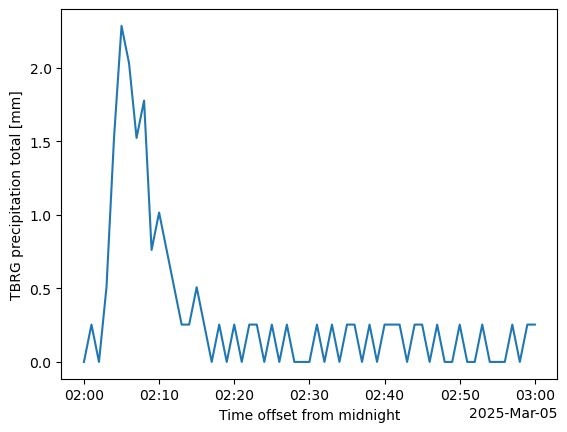

In [9]:
ds_met.tbrg_precip_total.sel(time=slice('2025-03-05T02:00:00.000000000', '2025-03-05T03:00:00.000000000')).plot()

## Radar Files

In [10]:
# With the user defined RADAR_DIR, grab all the XPRECIPRADAR CMAC files for the defined DATE
file_list = sorted(glob.glob(RADAR_DIR + 'bnfcsapr2cmacS3.c1.' + DATE.replace('-', '') + '*.nc'))
file_list[23]

'/nfs/gce/globalscratch/obrienj/bnf-cmac-r2/bnfcsapr2cmacS3.c1.20250305.020002.nc'

In [39]:
radar = pyart.io.read(file_list[23])

In [12]:
da = (pyart.util.columnsect.column_vertical_profile(radar, lats[4], lons[4]).interp(height=np.arange(radar.altitude['data'][0], 10050, 50)))

In [13]:
da

<xarray.Dataset> Size: 92kB
Dimensions:                                                (height: 201)
Coordinates:
  * height                                                 (height) float64 2kB ...
Data variables: (12/59)
    attenuation_corrected_differential_reflectivity        (height) float64 2kB ...
    attenuation_corrected_differential_reflectivity_lag_1  (height) float64 2kB ...
    attenuation_corrected_reflectivity_h                   (height) float64 2kB ...
    censor_mask                                            (height) float64 2kB ...
    classification_mask                                    (height) float64 2kB ...
    copol_correlation_coeff                                (height) float64 2kB ...
    ...                                                     ...
    path_integrated_differential_attenuation               (height) float64 2kB ...
    rain_rate_A                                            (height) float64 2kB ...
    time_offset                                            (height) float64 2kB ...
    base_time                                              datetime64[ns] 8B ...
    latitude                                               float64 8B 34.18
    longitude                                              float64 8B -87.45
Attributes:
    distance_from_radar:    58.174 km
    azimuth:                210.438 degrees
    latitude_of_location:   34.17932 degrees
    longitude_of_location:  -87.45349 degrees

In [14]:
column_list = []
for lat, lon in zip(lats, lons):
        print(lat, lon)
        # Make sure we are interpolating from the radar's location above sea level
        # NOTE: interpolating throughout Troposphere to match sonde to in the future
        try:
            da = (
                  pyart.util.columnsect.column_vertical_profile(radar, lat, lon)
                  .interp(height=np.arange(radar.altitude['data'][0], 8150, 150))
                )
        except:
              da = None
        ##except ValueError:
        ##    da = pyart.util.columnsect.column_vertical_profile(radar, lat, lon)
        # Add the latitude and longitude of the extracted column
        da["latitude"], da["longitude"] = lat, lon
        # Time is based off the start of the radar volume
        dt = pd.to_datetime(radar.time["data"], unit='ms')[-1]
        da["time"] = [dt]
        column_list.append(da)
        
# Concatenate the extracted radar columns for this scan across all sites    
ds = xr.concat(column_list, dim='station')
ds["station"] = sites

34.34525 -87.33842
34.46451 -87.23598
34.65401 -87.29264
34.38501 -86.92757
34.17932 -87.45349


In [15]:
ds

<xarray.Dataset> Size: 124kB
Dimensions:                                                (station: 5,
                                                            height: 55, time: 1)
Coordinates:
  * height                                                 (height) float64 440B ...
  * time                                                   (time) datetime64[ns] 8B ...
  * station                                                (station) <U3 60B ...
Data variables: (12/59)
    attenuation_corrected_differential_reflectivity        (station, height) float64 2kB ...
    attenuation_corrected_differential_reflectivity_lag_1  (station, height) float64 2kB ...
    attenuation_corrected_reflectivity_h                   (station, height) float64 2kB ...
    censor_mask                                            (station, height) float64 2kB ...
    classification_mask                                    (station, height) float64 2kB ...
    copol_correlation_coeff                                (station, height) float64 2kB ...
    ...                                                     ...
    path_integrated_differential_attenuation               (station, height) float64 2kB ...
    rain_rate_A                                            (station, height) float64 2kB ...
    time_offset                                            (station, height) float64 2kB ...
    base_time                                              (station) datetime64[ns] 40B ...
    latitude                                               (station) float64 40B ...
    longitude                                              (station) float64 40B ...
Attributes:
    distance_from_radar:    36.909 km
    azimuth:                210.709 degrees
    latitude_of_location:   34.34525 degrees
    longitude_of_location:  -87.33842 degrees

M1
S4
S20
S30
S40


Text(0.5, 1.0, 'RadClss - Single Columns - \n2025-03-05T02:00:02.000000000')

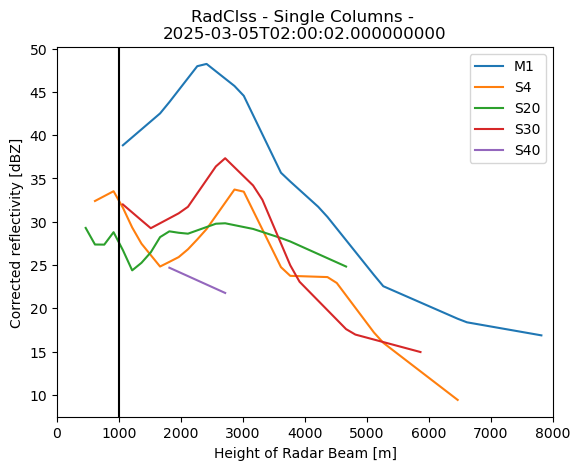

In [16]:
fig, axarr = plt.subplots(1, 1)
for site in ds.station.data:
    print(site)
    ds.corrected_reflectivity.sel(station=site).plot(ax=axarr,
                                                 label=site)
axarr.set_xlim([0, 8000])
axarr.legend(loc="upper right")
axarr.axvline(x=1000, ymin=0, ymax=60, color='black')
axarr.set_title("RadClss - Single Columns - \n" + str(ds.base_time.data[0]))

## Display the Cross Sections above a given location

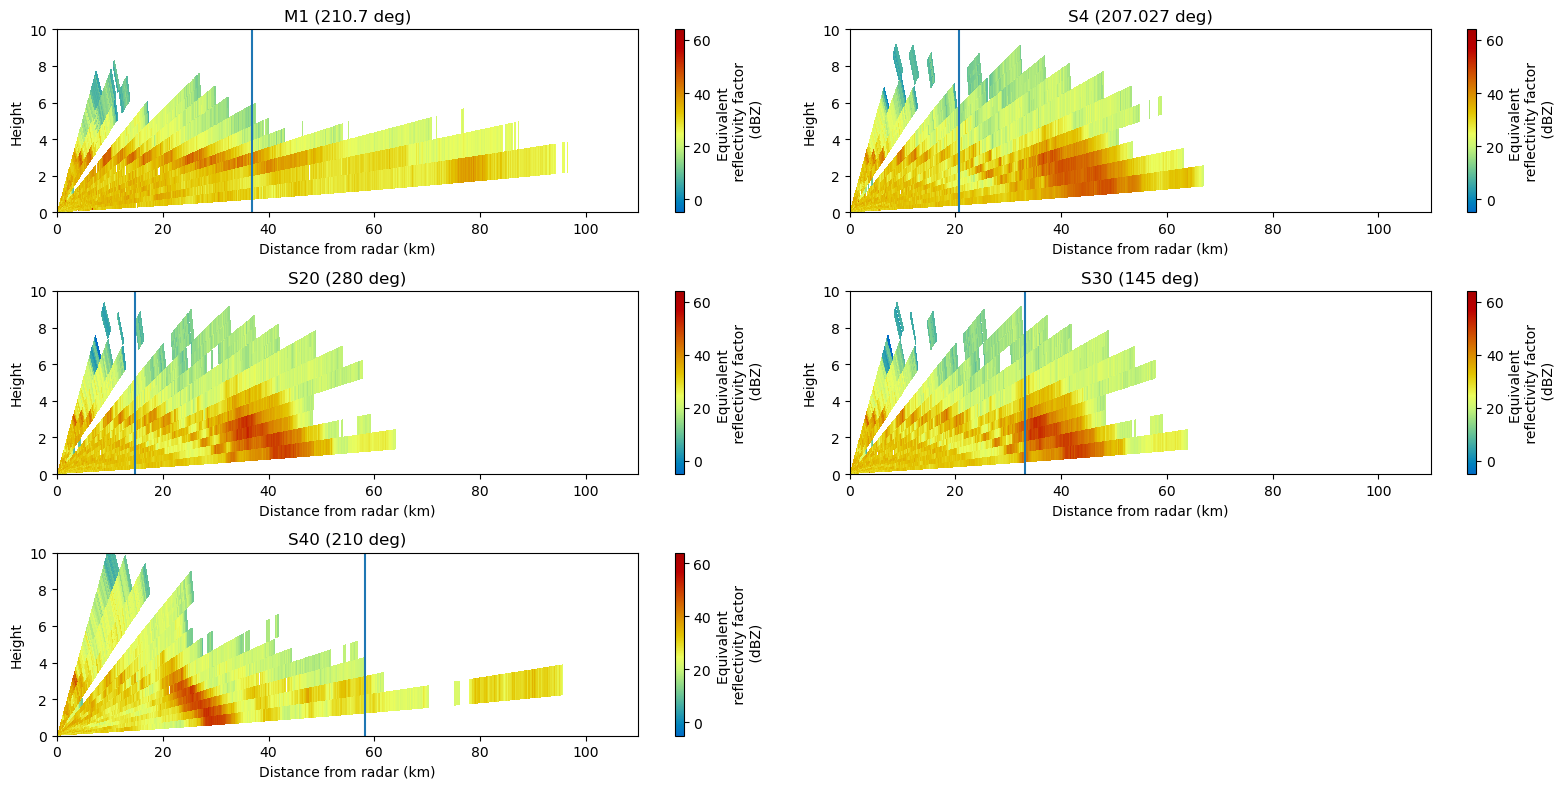

In [17]:
import matplotlib.pyplot as plt
# Read the data, a cfradial file
# Create a cross section at 225 and 270 degrees azimuth
xsect = pyart.util.cross_section_ppi(radar, [210.7, 207, 280, 145, 210.4], az_tol=0.5)

# Set the colorbar label
colorbar_label = "Equivalent \n reflectivity factor \n (dBZ)"

display = pyart.graph.RadarDisplay(xsect)
fig = plt.figure(figsize=[16, 8])

# M1
ax1 = fig.add_subplot(321)
display.plot(
    "corrected_reflectivity", 0, vmin=-5, vmax=64.0, colorbar_label=colorbar_label, ax=ax1
)
ax1.set_ylim(0, 10)
ax1.axvline(x=36.9, ymin=0, ymax=10)
ax1.set_ylabel("Height")
ax1.set_title("M1 (210.7 deg)")

# S4
ax2 = fig.add_subplot(322)
display.plot(
    "corrected_reflectivity", 1, vmin=-5, vmax=64.0, colorbar_label=colorbar_label, ax=ax2
)
ax2.set_ylim(0, 10)
ax2.axvline(x=20.753, ymin=0, ymax=10)
ax2.set_ylabel("Height")
ax2.set_title("S4 (207.027 deg)")

# S20
ax3 = fig.add_subplot(323)
display.plot(
    "corrected_reflectivity", 2, vmin=-5, vmax=64.0, colorbar_label=colorbar_label, ax=ax3
)
ax3.set_ylim(0, 10)
ax3.axvline(x=14.819, ymin=0, ymax=10)
ax3.set_ylabel("Height")
ax3.set_title("S20 (280 deg)")

# S30
ax4 = fig.add_subplot(324)
display.plot(
    "corrected_reflectivity", 3, vmin=-5, vmax=64.0, colorbar_label=colorbar_label, ax=ax4
)
ax4.set_ylim(0, 10)
ax4.axvline(x=33.192, ymin=0, ymax=10)
ax4.set_ylabel("Height")
ax4.set_title("S30 (145 deg)")

# S40
ax5 = fig.add_subplot(325)
display.plot(
    "corrected_reflectivity", 4, vmin=-5, vmax=64.0, colorbar_label=colorbar_label, ax=ax5
)
ax5.set_ylim(0, 10)
ax5.axvline(x=58.174, ymin=0, ymax=10)
ax5.set_ylabel("Height")
ax5.set_title("S40 (210 deg)")

plt.tight_layout()
plt.show()

## PPI Display

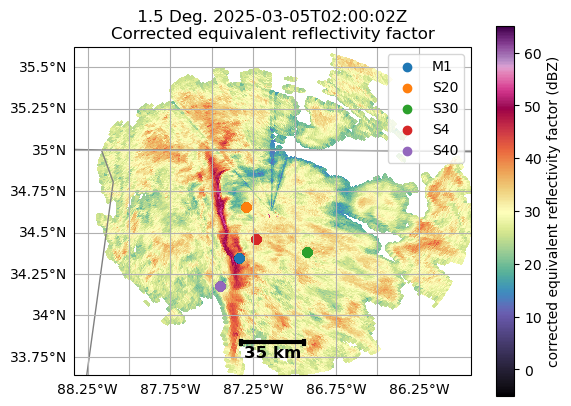

In [44]:
ax_rad = plt.subplot(111, projection=ccrs.PlateCarree())
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map("corrected_reflectivity", 
                     0, 
                     vmin=-5, 
                     vmax=65,
                     ax=ax_rad,
                     lon_lines=np.arange(-89, -86, 0.25),
                     lat_lines=np.arange(33.75, 35.75, 0.25),
                     cmap="ChaseSpectral"
                     )
for site in ds.station.data:
    ax_rad.scatter(ds.sel(station=site).longitude.data, 
                   ds.sel(station=site).latitude.data,
                   label=site)
ax_rad.legend(loc="upper right")

# Add our scale bar
add_scale_line(35.0, ax_rad, projection=ccrs.PlateCarree(), 
               color='black', linewidth=3,
               fontsize=12,
               fontweight='bold')

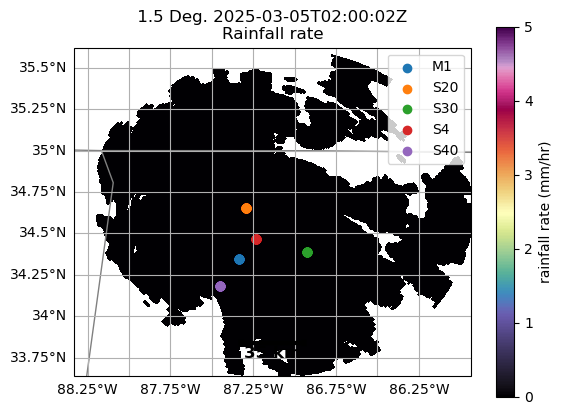

In [46]:
ax_rad = plt.subplot(111, projection=ccrs.PlateCarree())
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map("rain_rate_A", 
                     0, 
                     vmin=0, 
                     vmax=5,
                     ax=ax_rad,
                     lon_lines=np.arange(-89, -86, 0.25),
                     lat_lines=np.arange(33.75, 35.75, 0.25),
                     cmap="ChaseSpectral"
                     )
for site in ds.station.data:
    ax_rad.scatter(ds.sel(station=site).longitude.data, 
                   ds.sel(station=site).latitude.data,
                   label=site)
ax_rad.legend(loc="upper right")

# Add our scale bar
add_scale_line(35.0, ax_rad, projection=ccrs.PlateCarree(), 
               color='black', linewidth=3,
               fontsize=12,
               fontweight='bold')

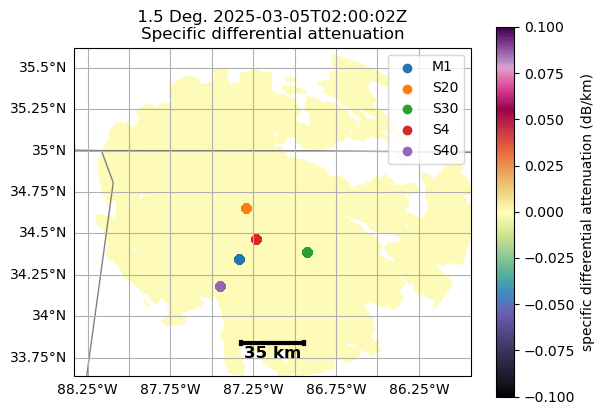

In [49]:
ax_rad = plt.subplot(111, projection=ccrs.PlateCarree())
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map("specific_differential_attenuation", 
                     0, 
                     ax=ax_rad,
                     lon_lines=np.arange(-89, -86, 0.25),
                     lat_lines=np.arange(33.75, 35.75, 0.25),
                     cmap="ChaseSpectral"
                     )
for site in ds.station.data:
    ax_rad.scatter(ds.sel(station=site).longitude.data, 
                   ds.sel(station=site).latitude.data,
                   label=site)
ax_rad.legend(loc="upper right")

# Add our scale bar
add_scale_line(35.0, ax_rad, projection=ccrs.PlateCarree(), 
               color='black', linewidth=3,
               fontsize=12,
               fontweight='bold')

In [19]:
del radar

## Full Daily RadClss

In [20]:
def subset_points(nfile, **kwargs):
    """
    Subset a radar file for a set of latitudes and longitudes
    utilizing Py-ART's column-vertical-profile functionality.

    Parameters
    ----------
    file : str
        Path to the radar file to extract columns from
    nsonde : list
        List containing file paths to the desired sonde file to merge

    Calls
    -----
    radar_start_time
    merge_sonde

    Returns
    -------
    ds : xarray DataSet
        Xarray Dataset containing the radar column above a give set of locations
    
    """
    ds = None
    
    # Define the splash locations [lon,lat]
    M1 = [34.34525, -87.33842]
    S4 = [34.46451,	-87.23598]
    S20 = [34.65401, -87.29264]
    S30	= [34.38501, -86.92757]
    S40	= [34.17932, -87.45349]

    sites = ["M1", "S4", "S20", "S30", "S40"]

    # Zip these together!
    lats, lons = list(zip(M1,
                          S4,
                          S20,
                          S30,
                          S40))
    try:
        # Read in the file
        radar = pyart.io.read(nfile)
        # Check for single sweep scans
        if np.ma.is_masked(radar.sweep_start_ray_index["data"][1:]):
            radar.sweep_start_ray_index["data"] = np.ma.array([0])
            radar.sweep_end_ray_index["data"] = np.ma.array([radar.nrays])
    except:
        radar = None

    if radar:
        if radar.scan_type != "rhi":
            # Easier to map the nearest sonde file to radar gates before extraction
            if 'sonde' in kwargs:
                # variables to discard when reading in the sonde file
                exclude_sonde = ['base_time', 'time_offset', 'lat', 'lon', 'qc_pres',
                                 'qc_tdry', 'qc_dp', 'qc_wspd', 'qc_deg', 'qc_rh',
                                 'qc_u_wind', 'qc_v_wind', 'qc_asc']
        
                # find the nearest sonde file to the radar start time
                radar_start = datetime.datetime.strptime(nfile.split('/')[-1].split('.')[-3] + '.' + nfile.split('/')[-1].split('.')[-2], 
                                                         '%Y%m%d.%H%M%S'
                )
                sonde_start = [datetime.datetime.strptime(xfile.split('/')[-1].split('.')[2] + 
                                                          '-' + 
                                                          xfile.split('/')[-1].split('.')[3], 
                                                          '%Y%m%d-%H%M%S') for xfile in kwargs['sonde']
                          ]
                # difference in time between radar file and each sonde file
                start_diff = [radar_start - sonde for sonde in sonde_start]

                # merge the sonde file into the radar object
                ds_sonde = act.io.read_arm_netcdf(kwargs['sonde'][start_diff.index(min(start_diff))], 
                                                  cleanup_qc=True, 
                                                  drop_variables=exclude_sonde)
   
                # create list of variables within sonde dataset to add to the radar file
                for var in list(ds_sonde.keys()):
                    if var != "alt":
                        z_dict, sonde_dict = pyart.retrieve.map_profile_to_gates(ds_sonde.variables[var],
                                                                                 ds_sonde.variables['alt'],
                                                                                 radar)
                    # add the field to the radar file
                    radar.add_field_like('corrected_reflectivity', "sonde_" + var,  sonde_dict['data'], replace_existing=True)
                    radar.fields["sonde_" + var]["units"] = sonde_dict["units"]
                    radar.fields["sonde_" + var]["long_name"] = sonde_dict["long_name"]
                    radar.fields["sonde_" + var]["standard_name"] = sonde_dict["standard_name"]
                    radar.fields["sonde_" + var]["datastream"] = ds_sonde.datastream

                del radar_start, sonde_start, ds_sonde
                del z_dict, sonde_dict
        
            column_list = []
            for lat, lon in zip(lats, lons):
                # Make sure we are interpolating from the radar's location above sea level
                # NOTE: interpolating throughout Troposphere to match sonde to in the future
                try:
                    da = (
                        pyart.util.columnsect.column_vertical_profile(radar, lat, lon)
                        .interp(height=np.arange(500, 8500, 250))
                    )
                except ValueError:
                    da = pyart.util.columnsect.column_vertical_profile(radar, lat, lon)
                    # drop the NaNs (and associated fields) from the extraction
                    da = da.isel(height=~np.isnan(da.height))
                    # interpolate to the same profile 
                    da = da.interp(height=np.arange(500, 8500, 250))

                # Interpolate NaNs out
                da = da.interpolate_na(dim="height", method="linear", fill_value="extrapolate")   
                # Add the latitude and longitude of the extracted column
                da["latitude"], da["longitude"] = lat, lon
                # Convert timeoffsets to timedelta object and precision on datetime64
                da.time_offset.data = da.time_offset.values.astype("timedelta64[s]")
                da.base_time.data = da.base_time.values.astype("datetime64[s]")
                # Time is based off the start of the radar volume
                da["gate_time"] = da.base_time.values + da.isel(height=0).time_offset.values
                column_list.append(da)
        
            # Concatenate the extracted radar columns for this scan across all sites    
            ds = xr.concat([data for data in column_list if data], dim='station')
            ds["station"] = sites
            # Add attributes for Time, Latitude, Longitude, and Sites
            ds.gate_time.attrs.update(long_name=('Time in Seconds that Cooresponds to the Start'
                                            + " of each Individual Radar Volume Scan before"
                                            + " Concatenation"),
                                 description=('Time in Seconds that Cooresponds to the Minimum'
                                              + ' Height Gate'))
            ds.time_offset.attrs.update(long_name=("Time in Seconds Since Midnight"),
                                        description=("Time in Seconds Since Midnight that Cooresponds"
                                                     + "to the Center of Each Height Gate"
                                                     + "Above the Target Location ")
                                        )
            ds.station.attrs.update(long_name="Bankhead National Forest AMF-3 In-Situ Ground Observation Station Identifers")
            ds.latitude.attrs.update(long_name='Latitude of BNF AMF-3 Ground Observation Site',
                                     units='Degrees North')
            ds.longitude.attrs.update(long_name='Longitude of BNF AMF-3 Ground Observation Site',
                                     units='Degrees East')
            # delete the radar to free up memory
            del radar, column_list, da
        else:
            # delete the rhi file
            del radar
    return ds

In [21]:
%%time
## Start up a Dask Cluster
cluster = LocalCluster(n_workers=4)
with Client(cluster) as client:
    future = client.map(subset_points, file_list)
    my_data = client.gather(future)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather 

2025-03-31 11:57:58,866 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:33423' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'subset_points-0868db1c86d7fca587a226d928285f58', 'subset_points-3720321775f7cd2d47607786023d8465', 'subset_points-29a0379af61843716538cba4af96345b', 'subset_points-05bebc7557e21204e82007e558741cbe', 'subset_points-1ddb3c382f325ee72562320ad7c13058', 'subset_points-0b61a4d23c2a5abc6e013a87ff44da32', 'subset_points-d03cfe370ea5923bd5e4702b710c60f2', 'subset_points-0da402c75d61e7f2dda73d6f316ea237'} (stimulus_id='handle-worker-cleanup-1743440278.8659244')
2025-03-31 11:57:58,880 - distributed.nanny - WARNING - Restarting worker



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



2025-03-31 11:58:04,658 - distributed.nanny - WARNING - Restarting worker



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

CPU times: user 47.4 s, sys: 13.2 s, total: 1min
Wall time: 9min 59s


In [22]:
ds = xr.concat([data for data in my_data if data], dim="time")
ds['time'] = ds.sel(station="M1").base_time

In [23]:
cluster.close()

2025-03-31 12:07:50,834 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/obrienj/miniforge3/envs/amf3-radar-examples-dev/lib/python3.11/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/obrienj/miniforge3/envs/amf3-radar-examples-dev/lib/python3.11/site-packages/distributed/worker.py", line 1269, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/obrienj/miniforge3/envs/amf3-radar-examples-dev/lib/python3.11/site-packages/distributed/utils_comm.py", line 416, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/home/obri

In [125]:
discard_var = {'radar' : ['classification_mask',
                          'censor_mask',
                          'uncorrected_copol_correlation_coeff',
                          'uncorrected_differential_phase',
                          'uncorrected_differential_reflectivity',
                          'uncorrected_differential_reflectivity_lag_1',
                          'uncorrected_mean_doppler_velocity_h',
                          'uncorrected_mean_doppler_velocity_v',
                          'uncorrected_reflectivity_h',
                          'uncorrected_reflectivity_v',
                          'uncorrected_spectral_width_h',
                          'uncorrected_spectral_width_v',
                          'clutter_masked_velocity',
                          'gate_id',
                          'ground_clutter',
                          'partial_beam_blockage',
                          'cumulative_beam_blockage',
                          'unfolded_differential_phase',
                          'path_integrated_attenuation',
                          'path_integrated_differential_attenuation',
                          'unthresholded_power_copolar_v',
                          'unthresholded_power_copolar_h',
                          'specific_differential_phase',
                          'specific_differential_attenuation',
                          'reflectivity_v',
                          'reflectivity',
                          'mean_doppler_velocity_v',
                          'mean_doppler_velocity',
                          'differential_reflectivity_lag_1',
                          'differential_reflectivity',
                          'differential_phase'
                ],
                'met' : ['base_time', 'time_offset', 'time_bounds', 'logger_volt',
                        'logger_temp', 'qc_logger_temp', 'lat', 'lon', 'alt', 'qc_temp_mean',
                        'qc_rh_mean', 'qc_vapor_pressure_mean', 'qc_wspd_arith_mean', 'qc_wspd_vec_mean',
                        'qc_wdir_vec_mean', 'qc_pwd_mean_vis_1min', 'qc_pwd_mean_vis_10min', 'qc_pwd_pw_code_inst',
                        'qc_pwd_pw_code_15min', 'qc_pwd_pw_code_1hr', 'qc_pwd_precip_rate_mean_1min',
                        'qc_pwd_cumul_rain', 'qc_pwd_cumul_snow', 'qc_org_precip_rate_mean', 'qc_tbrg_precip_total',
                        'qc_tbrg_precip_total_corr', 'qc_logger_volt', 'qc_logger_temp', 'qc_atmos_pressure', 
                        'pwd_pw_code_inst', 'pwd_pw_code_15min', 'pwd_pw_code_1hr', 'temp_std', 'rh_std',
                        'vapor_pressure_std', 'wdir_vec_std'
                ],
                'sonde' : ['base_time', 'time_offset', 'lat', 'lon', 'qc_pres',
                           'qc_tdry', 'qc_dp', 'qc_wspd', 'qc_deg', 'qc_rh',
                           'qc_u_wind', 'qc_v_wind', 'qc_asc', "wstat", "asc"
                ],
                'pluvio' : ['base_time', 'time_offset', 'load_cell_temp', 'heater_status',
                            'elec_unit_temp', 'supply_volts', 'orifice_temp', 'volt_min',
                            'ptemp', 'lat', 'lon', 'alt', 'maintenance_flag', 'reset_flag', 
                            'qc_rh_mean', 'pluvio_status', 'bucket_rt', 'accum_total_nrt'
                ],
                'ldquants' : ['specific_differential_attenuation_xband20c',
                              'specific_differential_attenuation_kaband20c',
                              'specific_differential_attenuation_sband20c',
                              'bringi_conv_stra_flag',
                              'exppsd_slope',
                              'norm_num_concen',
                              'num_concen',
                              'gammapsd_shape',
                              'gammapsd_slope',
                              'mean_doppler_vel_wband20c',
                              'mean_doppler_vel_kaband20c',
                              'mean_doppler_vel_xband20c',
                              'mean_doppler_vel_sband20c',
                              'specific_attenuation_kaband20c',
                              'specific_attenuation_xband20c',
                              'specific_attenuation_sband20c',
                              'specific_differential_phase_kaband20c',
                              'specific_differential_phase_xband20c',
                              'specific_differential_phase_sband20c',
                              'differential_reflectivity_kaband20c',
                              'differential_reflectivity_xband20c',
                              'differential_reflectivity_sband20c',
                              'reflectivity_factor_wband20c',
                              'reflectivity_factor_kaband20c',
                              'reflectivity_factor_xband20c',
                              'reflectivity_factor_sband20c',
                              'time_offset',
                              'base_time',
                              'lat',
                              'lon',
                              'alt'
                ]
}

In [25]:
ds = ds.drop_vars(discard_var["radar"])

In [26]:
ds

<xarray.Dataset> Size: 5MB
Dimensions:                                                (time: 143,
                                                            station: 5,
                                                            height: 32)
Coordinates:
  * height                                                 (height) int64 256B ...
  * station                                                (station) <U3 60B ...
  * time                                                   (time) datetime64[s] 1kB ...
Data variables: (12/29)
    attenuation_corrected_differential_reflectivity        (time, station, height) float64 183kB ...
    attenuation_corrected_differential_reflectivity_lag_1  (time, station, height) float64 183kB ...
    attenuation_corrected_reflectivity_h                   (time, station, height) float64 183kB ...
    copol_correlation_coeff                                (time, station, height) float64 183kB ...
    normalized_coherent_power                              (time, station, height) float64 183kB ...
    normalized_coherent_power_v                            (time, station, height) float64 183kB ...
    ...                                                     ...
    rain_rate_A                                            (time, station, height) float64 183kB ...
    time_offset                                            (time, station, height) timedelta64[s] 183kB ...
    base_time                                              (time, station) datetime64[s] 6kB ...
    latitude                                               (time, station) float64 6kB ...
    longitude                                              (time, station) float64 6kB ...
    gate_time                                              (time, station) datetime64[s] 6kB ...
Attributes:
    distance_from_radar:    36.909 km
    azimuth:                210.709 degrees
    latitude_of_location:   34.34525 degrees
    longitude_of_location:  -87.33842 degrees

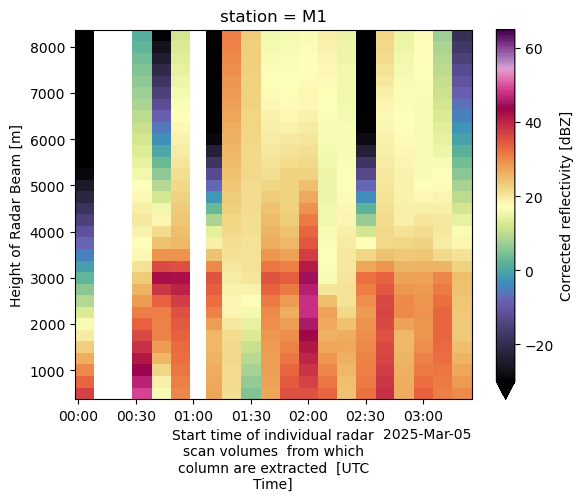

In [27]:
ds.sel(station="M1").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).corrected_reflectivity.plot(y="height", vmin=-30, vmax=65, cmap="ChaseSpectral")

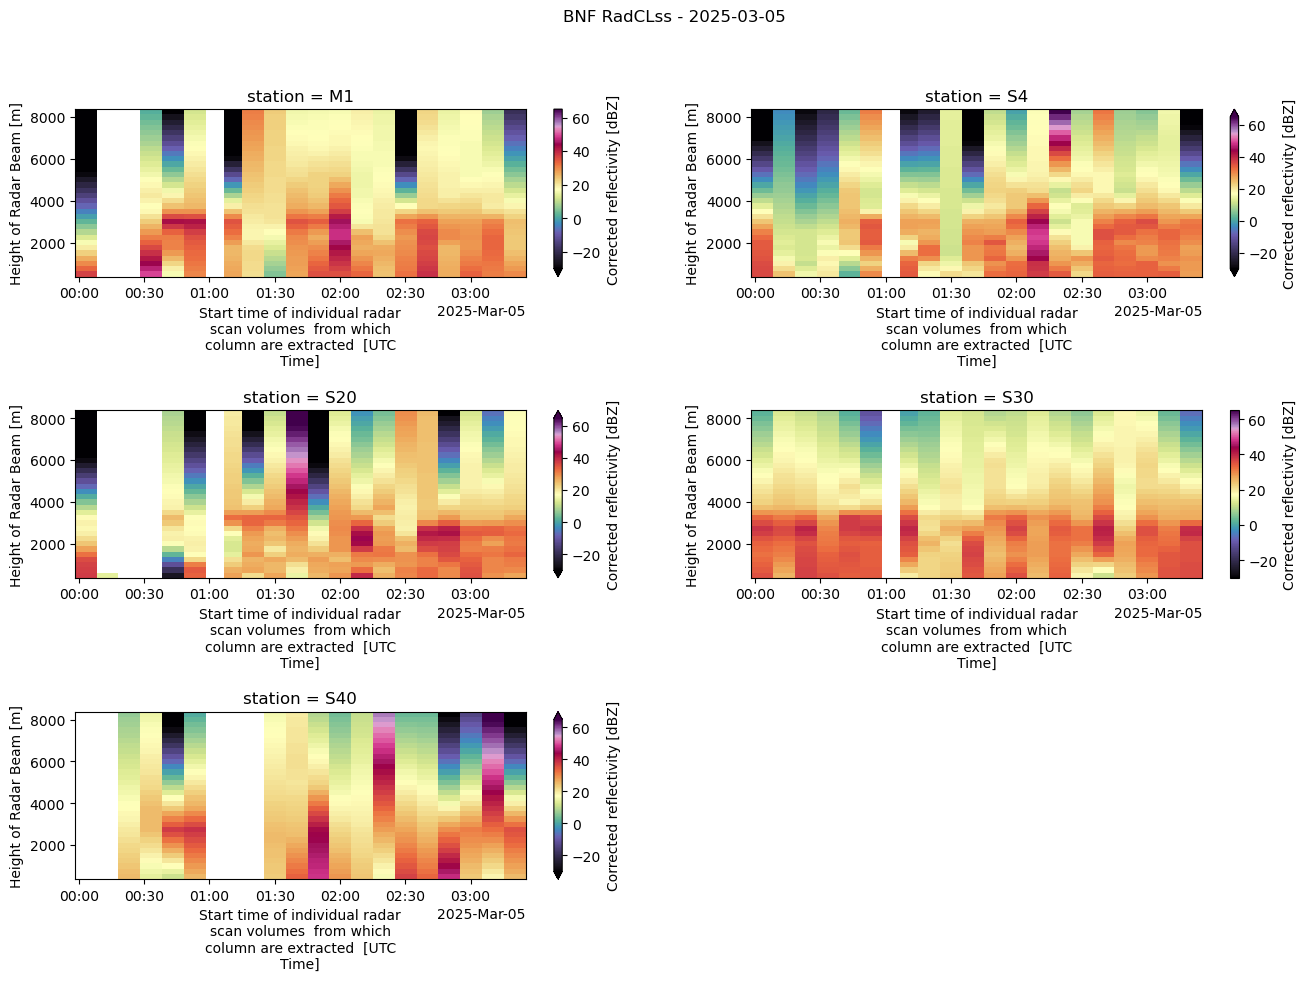

In [28]:
fig, axarr = plt.subplots(3, 2, figsize=[16, 10])
plt.subplots_adjust(hspace=0.8)

fig.suptitle("BNF RadCLss - " + DATE)

ds.sel(station="M1").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).corrected_reflectivity.plot(y="height", ax=axarr[0, 0], vmin=-30, vmax=65, cmap="ChaseSpectral")
ds.sel(station="S4").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).corrected_reflectivity.plot(y="height", ax=axarr[0, 1], vmin=-30, vmax=65, cmap="ChaseSpectral")
ds.sel(station="S20").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).corrected_reflectivity.plot(y="height", ax=axarr[1, 0], vmin=-30, vmax=65, cmap="ChaseSpectral")
ds.sel(station="S30").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).corrected_reflectivity.plot(y="height", ax=axarr[1, 1], vmin=-30, vmax=65, cmap="ChaseSpectral")
ds.sel(station="S40").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).corrected_reflectivity.plot(y="height", ax=axarr[2, 0], vmin=-30, vmax=65, cmap="ChaseSpectral")

axarr[2, 1].set_visible(False)

## Merge in the In-Situ

In [29]:
def match_datasets_act(column, ground, site, discard, resample='sum', DataSet=False):
    """
    Time synchronization of a Ground Instrumentation Dataset to 
    a Radar Column for Specific Locations using the ARM ACT package
    
    Parameters
    ----------
    column : Xarray DataSet
        Xarray DataSet containing the extracted radar column above multiple locations.
        Dimensions should include Time, Height, Site
             
    ground : str; Xarray DataSet
        String containing the path of the ground instrumentation file that is desired
        to be included within the extracted radar column dataset. 
        If DataSet is set to True, ground is Xarray Dataset and will skip I/O. 
             
    site : str
        Location of the ground instrument. Should be included within the filename. 
        
    discard : list
        List containing the desired input ground instrumentation variables to be 
        removed from the xarray DataSet. 
    
    resample : str
        Mathematical operational for resampling ground instrumentation to the radar time.
        Default is to sum the data across the resampling period. Checks for 'mean' or 
        to 'skip' altogether. 
    
    DataSet : boolean
        Boolean flag to determine if ground input is an Xarray Dataset.
        Set to True if ground input is Xarray DataSet. 
             
    Returns
    -------
    ds : Xarray DataSet
        Xarray Dataset containing the time-synced in-situ ground observations with
        the inputed radar column 
    """
    # Check to see if input is xarray DataSet or a file path
    if DataSet == True:
        grd_ds = ground
    else:
        # Read in the file using ACT
        grd_ds = act.io.read_arm_netcdf(ground, cleanup_qc=True, drop_variables=discard)
        # Default are Lazy Arrays; convert for matching with column
        grd_ds = grd_ds.compute()
        # Check to see if file is the RWP, 
        if 'rwp' in ground[0].split('/')[-1]:
            # adjust the RWP heights above ground level
            grd_ds['height'] = grd_ds.height.data + grd_ds.alt.data
        if 'ceil' in ground[0].split('/')[-1]:
            # correct ceilometer backscatter 
            grd_ds = act.corrections.correct_ceil(grd_ds, var_name='backscatter')
            # Rename the range dimension and apply altitude 
            grd_ds = grd_ds.rename({'range' : 'height'})
            grd_ds['height'] = grd_ds.height.data + grd_ds.alt.data
        
    # Remove Base_Time before Resampling Data since you can't force 1 datapoint to 5 min sum
    if 'base_time' in grd_ds.data_vars:
        del grd_ds['base_time']
        
    # Check to see if height is a dimension within the ground instrumentation. 
    # If so, first interpolate heights to match radar, before interpolating time.
    if 'height' in grd_ds.dims:
        grd_ds = grd_ds.interp(height=np.arange(3150, 10050, 50), method='linear')
        
    # Resample the ground data to 5 min and interpolate to the CSU X-Band time. 
    # Keep data variable attributes to help distingish between instruments/locations
    if resample.split('=')[-1] == 'mean':
        matched = grd_ds.resample(time='5Min', 
                                  closed='right').mean(keep_attrs=True).interp(time=column.time, 
                                                                               method='linear')
    elif resample.split('=')[-1] == 'skip':
        matched = grd_ds.interp(time=column.time, method='linear')
    else:
        matched = grd_ds.resample(time='5Min', 
                                  closed='right').sum(keep_attrs=True).interp(time=column.time, 
                                                                              method='linear')
    
    # Add SAIL site location as a dimension for the Pluvio data
    matched = matched.assign_coords(coords=dict(station=site))
    matched = matched.expand_dims('station')
   
    # Remove Lat/Lon Data variables as it is included within the Matched Dataset with Site Identfiers
    if 'lat' in matched.data_vars:
        del matched['lat']
    if 'lon' in matched.data_vars:
        del matched['lon']
    if 'alt' in matched.data_vars:
        del matched['alt']
        
    # Update the individual Variables to Hold Global Attributes
    # global attributes will be lost on merging into the matched dataset.
    # Need to keep as many references and descriptors as possible
    for var in matched.data_vars:
        matched[var].attrs.update(source=matched.datastream)
        
    # Merge the two DataSets
    column = xr.merge([column, matched])
   
    return column

### MET Instruments Across All Sites

In [ ]:
for stream in insitu_stream:
    if "bnfmet" in stream:
        if "M1" in stream:
            met_list = sorted(glob.glob(insitu_stream[stream] + "/*" + DATE.replace('-', '') + '*.cdf'))
            ds = match_datasets_act(ds, met_list[0], "M1", discard=discard_var['met'])
        else:
            met_list = sorted(glob.glob(insitu_stream[stream] + "/*" + DATE.replace('-', '') + '*.cdf'))
            met_site = met_list[0].split("/")[-1].split(".")[0][-3:]
            ds = match_datasets_act(ds, met_list[0], met_site, discard=discard_var['met'])

bnfmetM1.b1
bnfmetS20.b1
S20
bnfmetS30.b1
S30
bnfmetS40.b1
S40


(0.0, 10.0)

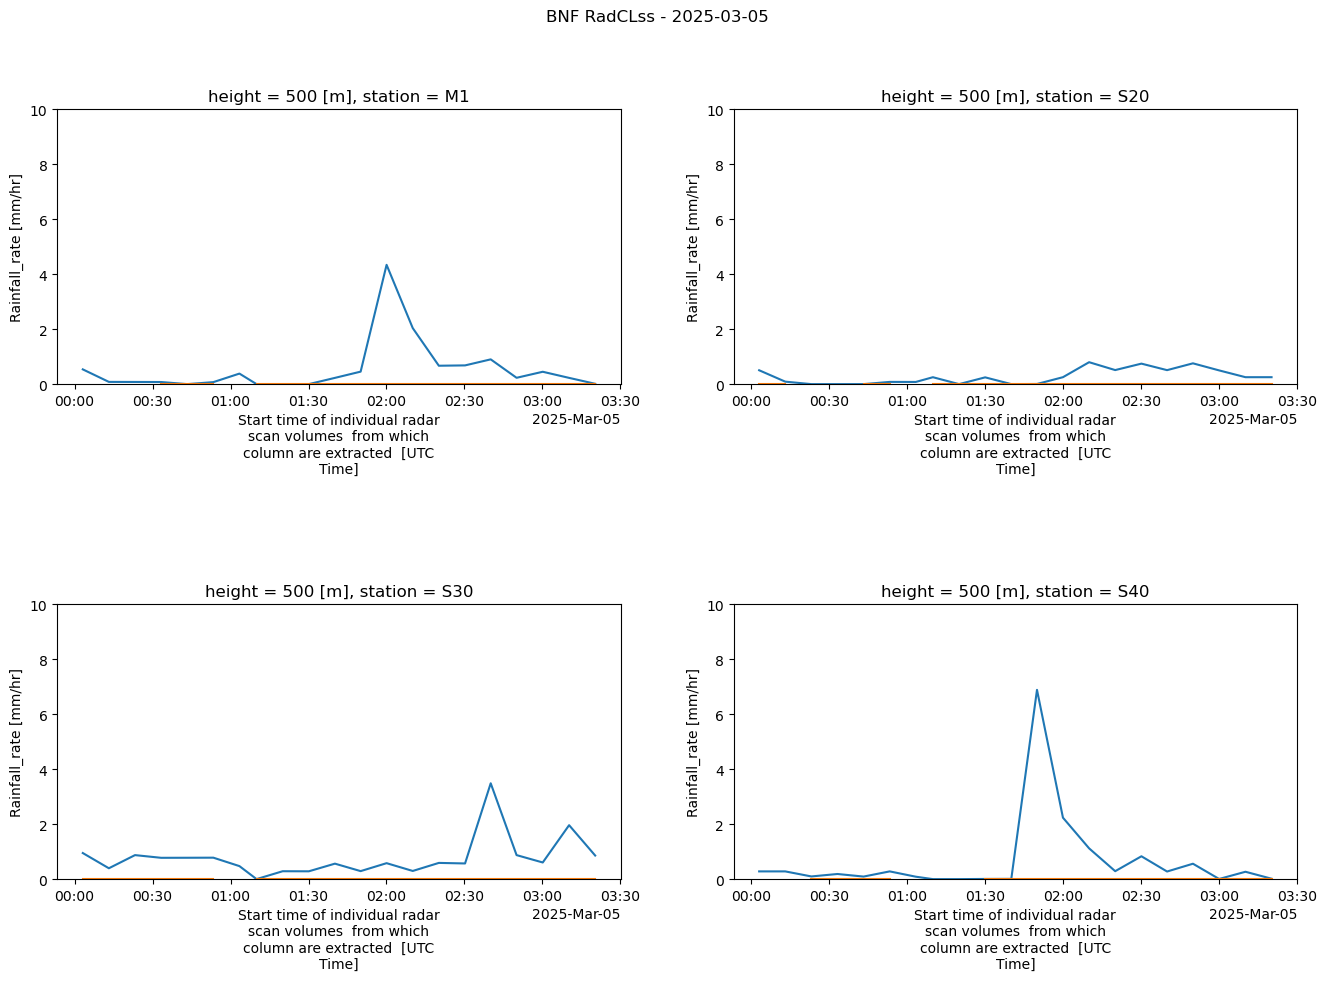

In [32]:
fig, axarr = plt.subplots(2, 2, figsize=[16, 10])
plt.subplots_adjust(hspace=0.8)

fig.suptitle("BNF RadCLss - " + DATE)

ds.sel(station="M1").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).tbrg_precip_total_corr.plot(x="time", ax=axarr[0, 0], label="MET TBRG")
ds.sel(station="M1").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).sel(height=500).rain_rate_A.plot(x="time", ax=axarr[0, 0], label="CMAC")
axarr[0, 0].set_ylim([0, 10])

ds.sel(station="S20").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).tbrg_precip_total_corr.plot(x="time", ax=axarr[0, 1], label="MET TBRG")
ds.sel(station="S20").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).sel(height=500).rain_rate_A.plot(x="time", ax=axarr[0, 1], label="CMAC")
axarr[0, 1].set_ylim([0, 10])

ds.sel(station="S30").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).tbrg_precip_total_corr.plot(x="time", ax=axarr[1, 0], label="MET TBRG")
ds.sel(station="S30").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).sel(height=500).rain_rate_A.plot(x="time", ax=axarr[1, 0], label="CMAC")
axarr[1, 0].set_ylim([0, 10])

ds.sel(station="S40").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).tbrg_precip_total_corr.plot(x="time", ax=axarr[1, 1], label="MET TBRG")
ds.sel(station="S40").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).sel(height=500).rain_rate_A.plot(x="time", ax=axarr[1, 1], label="CMAC")
axarr[1, 1].set_ylim([0, 10])

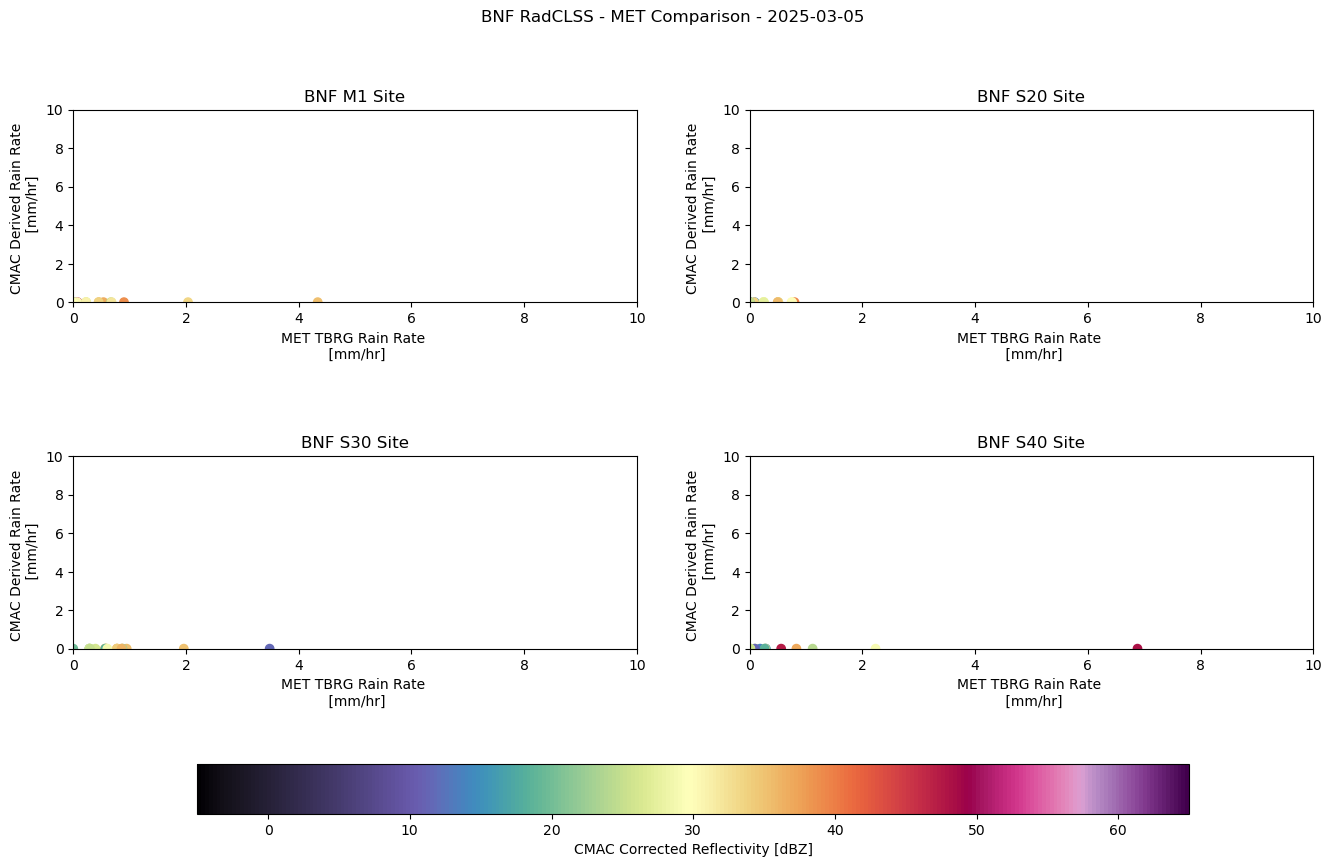

In [68]:
fig, axarr = plt.subplots(2, 2, figsize=[16, 10])
plt.subplots_adjust(hspace=0.8)

fig.suptitle("BNF RadCLSS - MET Comparison - " + DATE)

scatter = axarr[0, 0].scatter(ds.sel(station="M1").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).tbrg_precip_total_corr.data,
                              ds.sel(station="M1").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).sel(height=500).rain_rate_A,
                              c=ds.sel(station="M1").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).sel(height=500).corrected_reflectivity,
                              cmap="ChaseSpectral",
                              vmin=-5,
                              vmax=65
)
axarr[0, 0].set_ylim([0, 10])
axarr[0, 0].set_xlim([0, 10])
axarr[0, 0].set_xlabel("MET TBRG Rain Rate \n [mm/hr]")
axarr[0, 0].set_ylabel("CMAC Derived Rain Rate \n [mm/hr]")
axarr[0, 0].set_title("BNF M1 Site")

scatter = axarr[0, 1].scatter(ds.sel(station="S20").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).tbrg_precip_total_corr.data,
                              ds.sel(station="S20").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).sel(height=500).rain_rate_A,
                              c=ds.sel(station="S20").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).sel(height=500).corrected_reflectivity,
                              cmap="ChaseSpectral",
                              vmin=-5,
                              vmax=65
)
axarr[0, 1].set_ylim([0, 10])
axarr[0, 1].set_xlim([0, 10])
axarr[0, 1].set_xlabel("MET TBRG Rain Rate \n [mm/hr]")
axarr[0, 1].set_ylabel("CMAC Derived Rain Rate \n [mm/hr]")
axarr[0, 1].set_title("BNF S20 Site")

scatter = axarr[1, 0].scatter(ds.sel(station="S30").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).tbrg_precip_total_corr.data,
                              ds.sel(station="S30").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).sel(height=500).rain_rate_A,
                              c=ds.sel(station="S30").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).sel(height=500).corrected_reflectivity,
                              cmap="ChaseSpectral",
                              vmin=-5,
                              vmax=65
)
axarr[1, 0].set_ylim([0, 10])
axarr[1, 0].set_xlim([0, 10])
axarr[1, 0].set_xlabel("MET TBRG Rain Rate \n [mm/hr]")
axarr[1, 0].set_ylabel("CMAC Derived Rain Rate \n [mm/hr]")
axarr[1, 0].set_title("BNF S30 Site")

scatter = axarr[1, 1].scatter(ds.sel(station="S40").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).tbrg_precip_total_corr.data,
                              ds.sel(station="S40").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).sel(height=500).rain_rate_A,
                              c=ds.sel(station="S40").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).sel(height=500).corrected_reflectivity,
                              cmap="ChaseSpectral",
                              vmin=-5,
                              vmax=65
)
axarr[1, 1].set_ylim([0, 10])
axarr[1, 1].set_xlim([0, 10])
axarr[1, 1].set_xlabel("MET TBRG Rain Rate \n [mm/hr]")
axarr[1, 1].set_ylabel("CMAC Derived Rain Rate \n [mm/hr]")
axarr[1, 1].set_title("BNF S40 Site")

cbar = fig.colorbar(scatter, ax=axarr, location='bottom', shrink=0.8)
cbar.set_label("CMAC Corrected Reflectivity [dBZ]")

#ds.sel(station="M1").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).tbrg_precip_total_corr.plot(x="time", ax=axarr[0, 0], label="MET TBRG")
#ds.sel(station="M1").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).sel(height=500).rain_rate_A.plot(x="time", ax=axarr[0, 0], label="CMAC")
#axarr[0, 0].set_ylim([0, 10])

## Other In-Situ tests

In [124]:
# define the datastream and output directory
insitu_stream = {'bnfmetM1.b1' : INSITU_DIR + 'bnfmetM1.b1',
                 'bnfmetS20.b1' : INSITU_DIR + "bnfmetS20.b1",
                 "bnfmetS30.b1" : INSITU_DIR + "bnfmetS30.b1",
                 "bnfmetS40.b1" : INSITU_DIR + "bnfmetS40.b1",
                 "bnfsondewnpnM1.b1" : INSITU_DIR + "bnfsondewnpnM1.b1",
                 "bnfwbpluvio2M1.a1" : INSITU_DIR + "bnfwbpluvio2M1.a1",
                 "bnfldquantsM1.c1" : INSITU_DIR + "bnfldquantsM1.c1",
                 "bnfldquantsS30.c1" : INSITU_DIR + "bnfldquantsS30.c1",
                 "bnfvdisquantsM1.c1" : INSITU_DIR + "bnfvdisquantsM1.c1"
                }